In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [1]:
using_colab = False

## Set-up

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [3]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

In [6]:
import subprocess
import os
from pathlib import Path

def video_to_frames(input_video, output_dir, quality=2):
    """
    Convert a video file to a sequence of JPG frames.
    
    Args:
        input_video (str): Path to input video file
        output_dir (str): Directory to save the frames
        quality (int): JPEG quality (1-31, lower is better quality, 2 is recommended)
    
    Returns:
        int: Number of frames created, or -1 if error occurred
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Construct the ffmpeg command
    ffmpeg_cmd = [
        'ffmpeg',
        '-i', input_video,
        '-q:v', str(quality),
        '-start_number', '0',
        os.path.join(output_dir, '%05d.jpg')
    ]
    
    try:
        result = subprocess.run(
            ffmpeg_cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        
        if result.returncode == 0:
            num_frames = len([f for f in os.listdir(output_dir) if f.endswith('.jpg')])
            print(f"Successfully created {num_frames} frames from {input_video}")
            return num_frames
        else:
            print(f"Error processing {input_video}:")
            print(result.stderr)
            return -1
            
    except Exception as e:
        print(f"Error processing {input_video}: {str(e)}")
        return -1

# Example usage for multiple videos:


In [10]:
video_dir = "G:/SAM2/data_samples/thermalbabboon/"#"G:/SAM2/data_samples/babbling_eye_lid_tracking/"
videos = [f for f in os.listdir(video_dir) if f.endswith('.mp4')] #'.mov'

for video in videos:
    input_path = os.path.join(video_dir, video)
    output_dir = os.path.join(video_dir, Path(video).stem)
    video_to_frames(input_path, output_dir)

Successfully created 263 frames from G:/SAM2/data_samples/thermalbabboon/CutIndoorBreath+Rec-000024-278_09_59_28_244.mp4


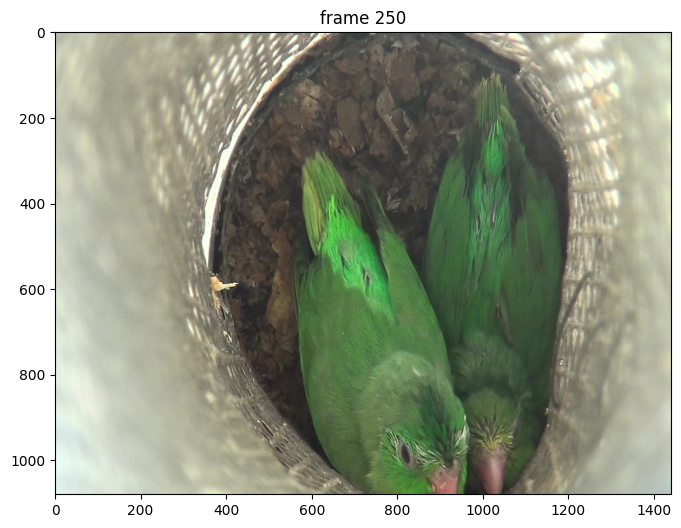

In [5]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "G:/SAM2/data_samples/babbling_eye_lid_tracking/18B17A_0801_0015_Movie1/" #"G:/SAM2/data_samples/babbling_eye_lid_tracking/18B104_0725_0011_0640_Movie2/"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 250
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [6]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|████████████████████████████████████████████████████████| 1169/1169 [00:50<00:00, 23.12it/s]


### Example 1: Segment & track one object

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [ ]:
predictor.reset_state(inference_state)

#### Step 1: Add a first click on a frame

To get started, let's try to segment the child on the left.

Here we make a **positive click** at (x, y) = (210, 350) with label `1`, by sending their coordinates and labels into the `add_new_points_or_box` API.

Note: label `1` indicates a *positive click (to add a region)* while label `0` indicates a *negative click (to remove a region)*.

Left click: add positive point
Right click: add negative point
Press 'Enter' to process the point
Press 'q' to quit without processing
Added positive point at (752, 563)
Added positive point at (766, 612)
Added positive point at (706, 567)
Added positive point at (701, 485)
Added positive point at (666, 458)
Added positive point at (655, 487)
Added positive point at (689, 456)
Added positive point at (642, 354)
Added positive point at (610, 378)
Added positive point at (665, 377)
Added negative point at (868, 696)
Added negative point at (696, 765)


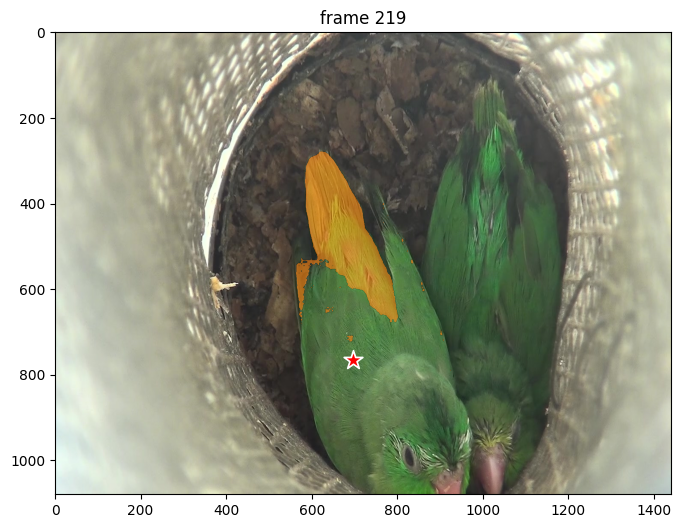

In [14]:
import cv2
import numpy as np
from PIL import Image

def click_handler(event, x, y, flags, param):
    global points, labels, img_display
    if event == cv2.EVENT_LBUTTONDOWN:  # Left click for positive
        points = np.array([[x, y]], dtype=np.float32)
        labels = np.array([1], np.int32)
        # Draw green circle for positive point
        cv2.circle(img_display, (x, y), 5, (0, 255, 0), -1)
        print(f"Added positive point at ({x}, {y})")
    elif event == cv2.EVENT_RBUTTONDOWN:  # Right click for negative
        points = np.array([[x, y]], dtype=np.float32)
        labels = np.array([0], np.int32)
        # Draw red circle for negative point
        cv2.circle(img_display, (x, y), 5, (0, 0, 255), -1)
        print(f"Added negative point at ({x}, {y})")

# Setup
ann_frame_idx = 1
ann_obj_id = 1

# Read image using OpenCV
img_path = os.path.join(video_dir, frame_names[ann_frame_idx])
img = cv2.imread(img_path)
img_display = img.copy()

# Create window and set mouse callback
cv2.namedWindow('image')
cv2.setMouseCallback('image', click_handler)

points = None
labels = None

print("Left click: add positive point")
print("Right click: add negative point")
print("Press 'Enter' to process the point")
print("Press 'q' to quit without processing")

while True:
    cv2.imshow('image', img_display)
    key = cv2.waitKey(1) & 0xFF
    
    if key == 13:  # Enter key
        if points is not None and labels is not None:
            cv2.destroyAllWindows()
            break
    elif key == ord('q'):
        cv2.destroyAllWindows()
        exit()

# Process the points if they exist
if points is not None and labels is not None:
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )

    # Show results using matplotlib
    plt.figure(figsize=(9, 6))
    plt.title(f"frame {ann_frame_idx}")
    plt.imshow(Image.open(img_path))
    show_points(points, labels, plt.gca())
    show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
    plt.show()

#### Step 2: Add a second click to refine the prediction

Hmm, it seems that although we wanted to segment the child on the left, the model predicts the mask for only the shorts -- this can happen since there is ambiguity from a single click about what the target object should be. We can refine the mask on this frame via another positive click on the child's shirt.

Here we make a **second positive click** at (x, y) = (250, 220) with label `1` to expand the mask.

Note: we need to send **all the clicks and their labels** (i.e. not just the last click) when calling `add_new_points_or_box`.

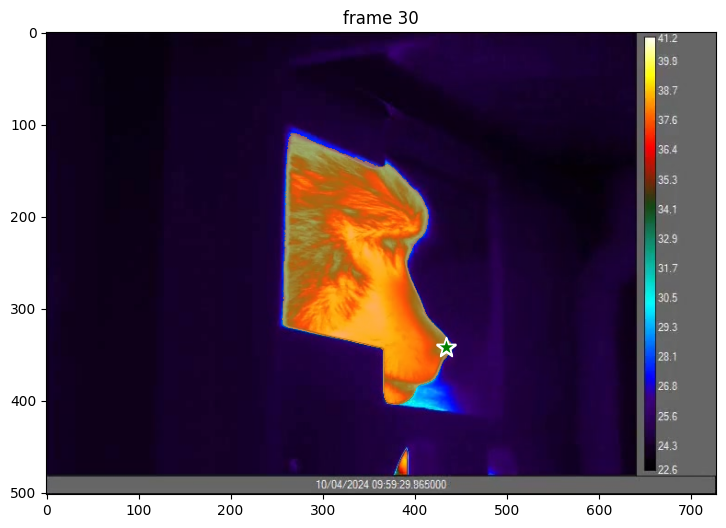

In [17]:
ann_frame_idx = 30  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[434, 343], [434, 342]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

With this 2nd refinement click, now we get a segmentation mask of the entire child on frame 0.

#### Step 3: Propagate the prompts to get the masklet across the video

To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

In [ ]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import pandas as pd
from scipy.ndimage import measurements

vis_frame_stride = 1

# Run propagation to get video_segments
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }
    
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def compute_box_from_mask(mask):
    # Ensure mask is 2D boolean array
    if len(mask.shape) > 2:
        mask = mask.squeeze()
    mask = mask.astype(bool)
    
    # Find coordinates of mask pixels
    coords = np.argwhere(mask)
    if len(coords) == 0:
        return None
        
    # Get bounding box coordinates with padding
    padding = 10
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0)
    
    # Add padding
    x0 = max(0, x0 - padding)
    x1 = x1 + padding
    y0 = max(0, y0 - padding)
    y1 = y1 + padding
    
    return [int(x0), int(y0), int(x1), int(y1)]

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def compute_centroid(mask):
    """Calculate centroid of a binary mask"""
    if not mask.any():
        return None
    
    # Ensure mask is 2D boolean array
    if len(mask.shape) > 2:
        mask = mask.squeeze()
    mask = mask.astype(bool)
    
    # Get coordinates of True values
    y_coords, x_coords = np.where(mask)
    
    if len(y_coords) == 0:
        return None
        
    # Calculate centroid
    centroid_y = np.mean(y_coords)
    centroid_x = np.mean(x_coords)
    
    return (centroid_y, centroid_x)

def compute_metrics(mask, box):
    """Compute all metrics for a frame"""
    if box is None or mask is None:
        return None
    
    # Ensure mask is 2D boolean array
    if len(mask.shape) > 2:
        mask = mask.squeeze()
    mask = mask.astype(bool)
    
    # Box coordinates
    x1, y1, x2, y2 = box
    
    # Box centroid
    box_centroid_x = (x1 + x2) / 2
    box_centroid_y = (y1 + y2) / 2
    
    # Segmentation metrics
    seg_centroid = compute_centroid(mask)
    if seg_centroid is None:
        return None
    
    # Surface area (number of True pixels in mask)
    surface_area = np.sum(mask)
    
    # Get segmentation coordinates (boundary points)
    seg_coords = np.argwhere(mask)
    
    # For debugging
    print(f"Mask shape: {mask.shape}")
    print(f"True pixels: {np.sum(mask)}")
    print(f"Centroid: {seg_centroid}")
    
    return {
        'box_x1': x1,
        'box_y1': y1,
        'box_x2': x2,
        'box_y2': y2,
        'box_centroid_x': box_centroid_x,
        'box_centroid_y': box_centroid_y,
        'seg_centroid_y': float(seg_centroid[0]),  # y coordinate
        'seg_centroid_x': float(seg_centroid[1]),  # x coordinate
        'surface_area': surface_area,
        'seg_coords': seg_coords.tolist()  # Convert to list for CSV storage
    }
    
# Create output directories
output_dir = os.path.join(video_dir, "visualization_frames")
output_dir_cropped = os.path.join(video_dir, "cropped_frames")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir_cropped, exist_ok=True)

# Process and save each frame
max_crop_width = 0
max_crop_height = 0

# Create a list to store frame data
frame_data = []

# First pass to determine maximum crop dimensions
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    if out_frame_idx in video_segments:
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            if len(out_mask.shape) >= 2:
                box = compute_box_from_mask(out_mask)
                if box is not None:
                    crop_width = box[2] - box[0]
                    crop_height = box[3] - box[1]
                    max_crop_width = max(max_crop_width, crop_width)
                    max_crop_height = max(max_crop_height, crop_height)

# Second pass to create frames
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    # Create the visualization
    plt.figure(figsize=(6, 4))
    ax = plt.gca()
    
    # Show the base image
    img = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    img_np = np.array(img)
    ax.imshow(img)
    
    # Try to show masks and boxes if they exist
    box = None
    if out_frame_idx in video_segments:
        try:
            for out_obj_id, out_mask in video_segments[out_frame_idx].items():
                if len(out_mask.shape) >= 2:
                    show_mask(out_mask, ax, obj_id=out_obj_id)
                    box = compute_box_from_mask(out_mask)
                    if box is not None:
                        show_box(box, ax)
                        # Compute metrics
                        metrics = compute_metrics(out_mask, box)
                        if metrics is not None:
                            metrics['frame_idx'] = out_frame_idx
                            metrics['obj_id'] = out_obj_id
                            frame_data.append(metrics)
        except Exception as e:
            print(f"Warning: Could not show mask/box for frame {out_frame_idx}: {str(e)}")
    
    plt.title(f"frame {out_frame_idx}")
    
    # Save the full frame
    output_path = os.path.join(output_dir, f"frame_{out_frame_idx:05d}.png")
    plt.savefig(output_path, bbox_inches='tight', dpi=150)
    plt.close()
    
    # Save the cropped frame if box exists
    if box is not None:
        cropped_img = img_np[box[1]:box[3], box[0]:box[2]]
        # Pad to maximum dimensions
        padded_img = np.zeros((max_crop_height, max_crop_width, 3), dtype=np.uint8)
        padded_img[:cropped_img.shape[0], :cropped_img.shape[1]] = cropped_img
        cv2.imwrite(os.path.join(output_dir_cropped, f"frame_{out_frame_idx:05d}.png"), 
                   cv2.cvtColor(padded_img, cv2.COLOR_RGB2BGR))
    
    if out_frame_idx % 10 == 0:
        print(f"Processed frame {out_frame_idx}/{len(frame_names)}")

# Create full video
frames_to_video = True
if frames_to_video:
    # Full video
    first_frame = cv2.imread(os.path.join(output_dir, f"frame_{0:05d}.png"))
    height, width = first_frame.shape[:2]
    
    output_video = os.path.join(video_dir, "visualization.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, 30, (width, height))
    
    frame_files = sorted([f for f in os.listdir(output_dir) if f.endswith('.png')])
    for frame_file in frame_files:
        frame = cv2.imread(os.path.join(output_dir, frame_file))
        out.write(frame)
    out.release()
    
    # Cropped video
    output_video_cropped = os.path.join(video_dir, "cropped.mp4")
    out_cropped = cv2.VideoWriter(output_video_cropped, fourcc, 30, 
                                 (max_crop_width, max_crop_height))
    
    frame_files = sorted([f for f in os.listdir(output_dir_cropped) if f.endswith('.png')])
    for frame_file in frame_files:
        frame = cv2.imread(os.path.join(output_dir_cropped, frame_file))
        out_cropped.write(frame)
    out_cropped.release()
    
    print(f"Videos saved to: {output_video} and {output_video_cropped}")

# Create DataFrame and save metrics to CSV
df = pd.DataFrame(frame_data)

# Optionally, save segmentation coordinates to a separate file
seg_coords_data = df[['frame_idx', 'obj_id', 'seg_coords']].copy()
df = df.drop('seg_coords', axis=1)  # Remove seg_coords from main DataFrame

# Save to CSV
metrics_csv_path = os.path.join(video_dir, "frame_metrics.csv")
df.to_csv(metrics_csv_path, index=False)

# Save segmentation coordinates to a separate file
coords_csv_path = os.path.join(video_dir, "segmentation_coords.csv")
seg_coords_data.to_csv(coords_csv_path, index=False)

# Print summary
print("\nProcessing Summary:")
print(f"Total frames processed: {len(frame_names)}")
print(f"Frames with masks: {len(video_segments)}")
print(f"Maximum crop dimensions: {max_crop_width}x{max_crop_height}")
print(f"Output files created:")
print(f"- Full frames: {output_dir}")
print(f"- Cropped frames: {output_dir_cropped}")
print(f"- Metrics CSV: {metrics_csv_path}")
print(f"- Segmentation coordinates: {coords_csv_path}")
if frames_to_video:
    print(f"- Full video: {output_video}")
    print(f"- Cropped video: {output_video_cropped}")

# Print metrics summary
print("\nMetrics Summary:")
print(df.describe())

propagate in video:   0%|                                                                      | 0/950 [00:00<?, ?it/s]G:\SAM2\sam2\sam2\modeling\sam\transformer.py:344: UserWarning: Memory efficient kernel not used because: (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:778.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
G:\SAM2\sam2\sam2\modeling\sam\transformer.py:344: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/transformers/sdp_utils_cpp.h:558.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
G:\SAM2\sam2\sam2\modeling\sam\transformer.py:344: UserWarning: Flash attention kernel not used because: (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformer

Processed frame 0/1169
Processed frame 10/1169
Processed frame 20/1169
Processed frame 30/1169
Processed frame 40/1169
Processed frame 50/1169
Processed frame 60/1169
Processed frame 70/1169
Processed frame 80/1169
Processed frame 90/1169
Processed frame 100/1169
Processed frame 110/1169
Processed frame 120/1169
Processed frame 130/1169
Processed frame 140/1169


# Optional: Also create coco formatted segmentation info

In [22]:
import json
from datetime import datetime

# Create COCO format annotations
current_time = datetime.now().strftime("%a %b %d %Y %H:%M:%S GMT%z (%Z)")
coco_data = {
    "info": {
        "year": 2024,
        "version": "1.0",
        "description": "VIA project exported to COCO format using SAM2",
        "contributor": "SAM2 & Wim Pouw",
        "url": "NA",
        "date_created": current_time
    },
    "images": [],
    "annotations": [],
    "licenses": [{"id": 0, "name": "Unknown License", "url": ""}],
    "categories": [{"supercategory": "animal_body", "id": 1, "name": "animal_body"}]
}

# Add images with sequential IDs
unique_ids = {}
for idx, frame_name in enumerate(frame_names, 1):  # Start from 1
    img = Image.open(os.path.join(video_dir, frame_name))
    width, height = img.size
    coco_data["images"].append({
        "id": idx,
        "width": width,
        "height": height,
        "file_name": frame_name,
        "license": 0,
        "date_captured": ""
    })
    unique_ids[frame_name] = idx

# Add annotations
annotation_id = 1
for frame_idx in range(len(frame_names)):
    if frame_idx in video_segments:
        current_frame = frame_names[frame_idx]
        for obj_id, mask in video_segments[frame_idx].items():
            # Ensure mask is 2D and binary
            if len(mask.shape) > 2:
                mask = mask.squeeze()
            mask_bool = mask.astype(np.uint8) * 255

            # Find contours - use CHAIN_APPROX_SIMPLE for fewer points
            contours, _ = cv2.findContours(mask_bool, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            if len(contours) > 0:
                # Get the largest contour
                contour = max(contours, key=cv2.contourArea)
                
                # Simplify the contour
                epsilon = 0.005 * cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, epsilon, True)
                
                # Convert to the format in your example: [x1,y1,x2,y2,...]
                flattened = []
                for point in approx:
                    flattened.extend([int(point[0][0]), int(point[0][1])])

                # Calculate bounding box
                box = compute_box_from_mask(mask)
                if box is not None:
                    x1, y1, x2, y2 = box
                    bbox = [x1, y1, x2 - x1, y2 - y1]
                    
                    # Calculate area
                    area = int(cv2.contourArea(contour))
                    
                    coco_data["annotations"].append({
                        "segmentation": [flattened],  # Single list of coordinates
                        "area": area,
                        "bbox": bbox,
                        "iscrowd": 0,
                        "id": annotation_id,
                        "image_id": unique_ids[current_frame],
                        "category_id": 1
                    })
                    annotation_id += 1

# Save COCO JSON
coco_json_path = os.path.join(video_dir, "segmentation_coco.json")
with open(coco_json_path, 'w', encoding='utf-8') as f:
    json.dump(coco_data, f)

print(f"- COCO format annotations: {coco_json_path}")

- COCO format annotations: G:/SAM2/data_samples/thermalbabboon/CutIndoorBreath+Rec-000024-278_09_59_28_244/segmentation_coco.json


### Train detectron2 with segmentation (to do)

You can now import COCO formatted segmentations into detectron2. We also need a script that combines json files into a single if we are using a lot of different videos.

### Example 3: Segment multiple objects simultaneously (TO DO for the entire above code)

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

In [20]:
predictor.reset_state(inference_state)

#### Step 1: Add two objects on a frame

SAM 2 can also segment and track two or more objects at the same time. One way, of course, is to do them one by one. However, it would be more efficient to batch them together (e.g. so that we can share the image features between objects to reduce computation costs).

This time, let's focus on object parts and segment **the shirts of both childen** in this video. Here we add prompts for these two objects and assign each of them a unique object id.

In [21]:
prompts = {}  # hold all the clicks we add for visualization

Add the first object (the left child's shirt) with a **positive click** at (x, y) = (200, 300) on frame 0.

We assign it to object id `2` (it can be arbitrary integers, and only needs to be unique for each object to track), which is passed to the `add_new_points_or_box` API to distinguish the object we are clicking upon.

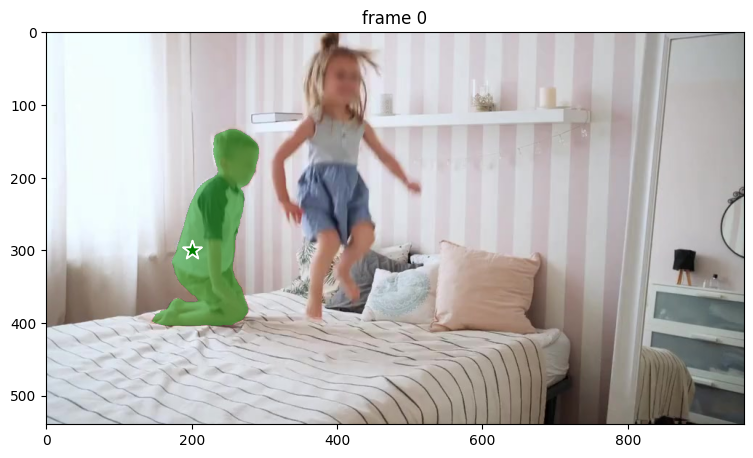

In [22]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (200, 300) to get started on the first object
points = np.array([[200, 300]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

Hmm, this time we just want to select the child's shirt, but the model predicts the mask for the entire child. Let's refine the prediction with a **negative click** at (x, y) = (275, 175).

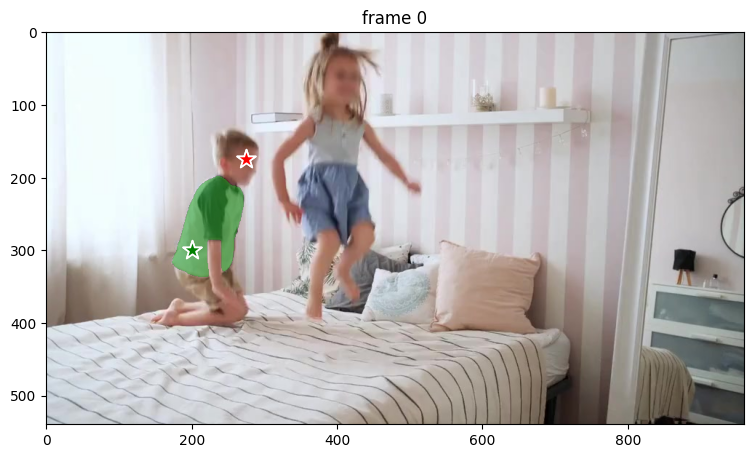

In [23]:
# add the first object
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd negative click at (x, y) = (275, 175) to refine the first object
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[200, 300], [275, 175]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 0], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

After the 2nd negative click, now we get the left child's shirt as our first object.

Let's move on to the second object (the right child's shirt) with a positive click at (x, y) = (400, 150) on frame 0. Here we assign object id `3` to this second object (it can be arbitrary integers, and only needs to be unique for each object to track).

Note: when there are multiple objects, the `add_new_points_or_box` API will return a list of masks for each object.

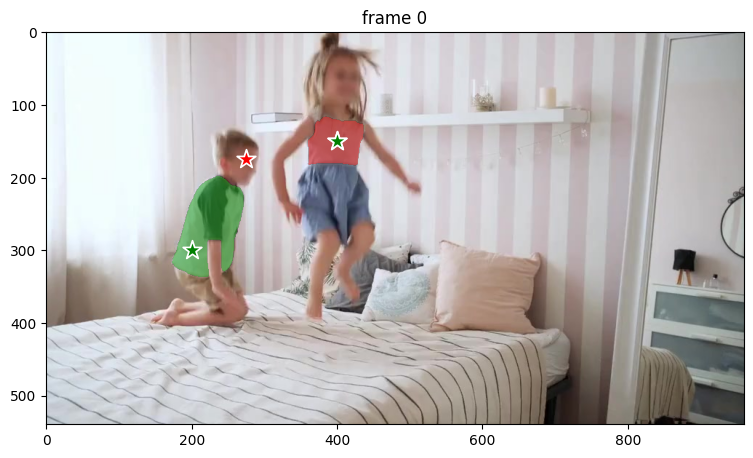

In [24]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 3  # give a unique id to each object we interact with (it can be any integers)

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
points = np.array([[400, 150]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame on all objects
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

This time the model predicts the mask of the shirt we want to track in just one click. Nice!

#### Step 2: Propagate the prompts to get masklets across the video

Now, we propagate the prompts for both objects to get their masklets throughout the video.

Note: when there are multiple objects, the `propagate_in_video` API will return a list of masks for each object.

propagate in video: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 18.87it/s]


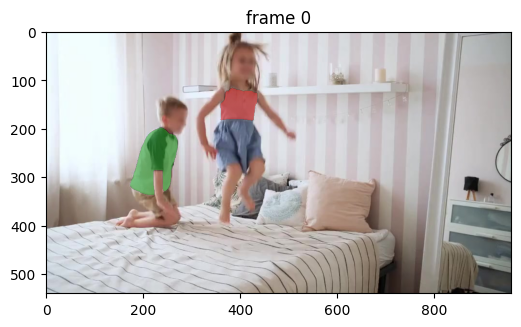

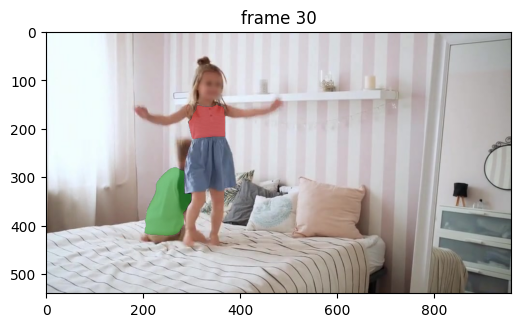

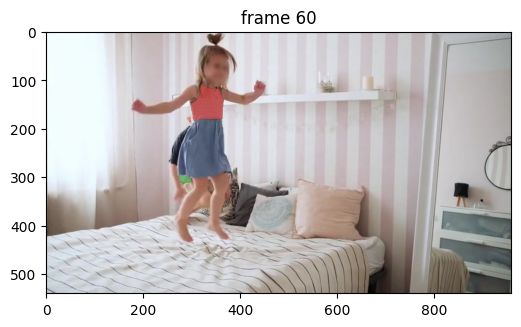

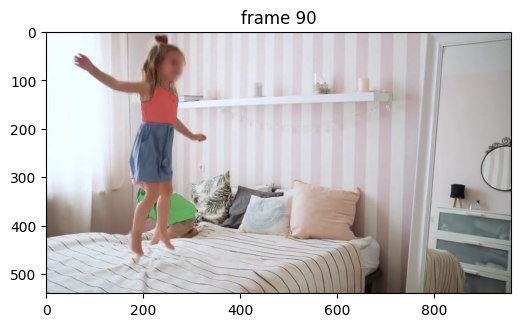

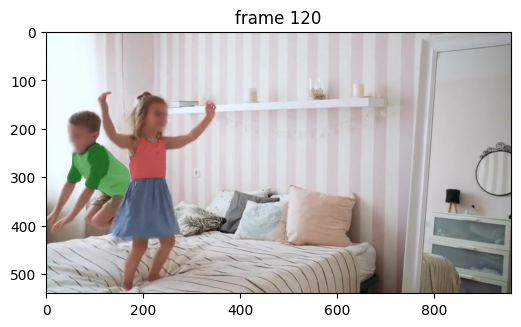

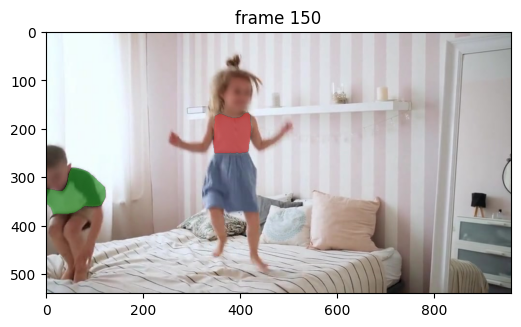

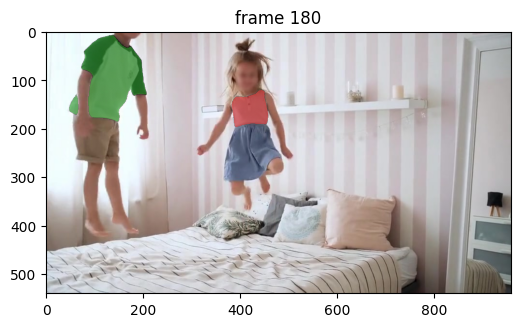

In [25]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

Looks like both children's shirts are well segmented in this video.

Now you can try SAM 2 on your own videos and use cases! 